## Get Data

In [1]:
!pip install scikit-multilearn
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.24.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 7.9 MB/s 
Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.1 which is incompatible.


In [2]:
from google.colab import drive
from psutil import virtual_memory

drive.mount('/content/gdrive/', force_remount=True)
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Mounted at /content/gdrive/
Your runtime has 54.8 gigabytes of available RAM



In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, normalize, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, classification_report, confusion_matrix

import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


import tensorflow as tf
from tensorflow.python.keras import layers
from skmultilearn.adapt import MLkNN

import warnings
warnings.filterwarnings('ignore')

In [4]:
os.chdir("gdrive/MyDrive/Dissertation/ukdale")

In [5]:
data = pd.read_csv('processed_data/125_tsfresh_labeled.csv', index_col=[0])
print(data.shape)

(931117, 792)


In [6]:
data.head()

,aggregate__variance_larger_than_standard_deviation,aggregate__has_duplicate_max,aggregate__has_duplicate_min,aggregate__has_duplicate,aggregate__sum_values,aggregate__abs_energy,aggregate__mean_abs_change,aggregate__mean_change,aggregate__mean_second_derivative_central,aggregate__median,...,"aggregate__matrix_profile__feature_""min""__threshold_0.98","aggregate__matrix_profile__feature_""max""__threshold_0.98","aggregate__matrix_profile__feature_""mean""__threshold_0.98","aggregate__matrix_profile__feature_""median""__threshold_0.98","aggregate__matrix_profile__feature_""25""__threshold_0.98","aggregate__matrix_profile__feature_""75""__threshold_0.98",aggregate__mean_n_absolute_max__number_of_maxima_7,1,2,3
0.0,0.0,1.0,1.0,1.0,1501.0,250335.0,0.125000,-0.125000,0.0000,167.0,...,0.0,0.0,0.0,0.0,0.0,0.0,167.000000,0,all_off,all_off
1.0,1.0,0.0,0.0,1.0,1674.0,280238.0,0.888889,0.000000,-0.0625,167.0,...,0.0,0.0,0.0,0.0,0.0,0.0,167.714286,0,all_off,all_off
2.0,0.0,1.0,0.0,1.0,1682.0,282916.0,0.888889,0.000000,-0.0625,168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,168.428571,0,all_off,all_off
3.0,0.0,1.0,1.0,1.0,1677.0,281235.0,0.111111,-0.111111,0.0000,168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,168.000000,0,all_off,all_off
4.0,1.0,0.0,0.0,1.0,1675.0,280573.0,1.111111,0.222222,0.0000,167.0,...,0.0,0.0,0.0,0.0,0.0,0.0,167.857143,0,all_off,all_off


In [7]:
features = data.loc[:568302,~data.columns.isin(['1','2','3'])]
labels = data['2'].loc[:568302].str.split(', ')

X = features.loc[:, features.nunique() > 1]
print(features.shape)

encoding = MultiLabelBinarizer()
y = encoding.fit_transform(labels)
print(encoding.classes_)
print(y.shape)

# Train test split
Xtr, Xt, ytr, yt = train_test_split(X, y, test_size=0.3, random_state=43, shuffle=True, stratify=y)

(568303, 789)
['all_off' 'fridge' 'washing_machine']
(568303, 3)


## Feature selection

### Find and drop correlated features

In [8]:
def correlation(data, threshold):
    corr = set()
    corr_mat = data.corr()
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if (corr_mat.iloc[i,j]) > threshold:
                col = corr_mat.columns[i]
                corr.add(col)
    return corr

# Find correlated columns in train data
cols = correlation(Xtr, 0.85)
print(len(set(cols)))

113


In [9]:
# Remove correlated columns from train and test data
Xtr = Xtr.drop(cols, axis=1)
Xt = Xt.drop(cols, axis=1)

### Scaling and encoding features and labels

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(Xtr)
X_test = scaler.transform(Xt)
y_train = ytr
y_test = yt

## Performance metrics

In [22]:
def model_scores(ypred, ytest):
    print(f'Accuracy : {accuracy_score(ytest, ypred)}')
    print(f'Mean absolute error : {mean_absolute_error(ytest, ypred)}')
    print(classification_report(ytest, ypred))

    cm = confusion_matrix(ytest.argmax(axis=1), ypred.argmax(axis=1))
    plt.figure(figsize = (10,7))

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax = ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.xaxis.set_ticklabels(['OFF states', 'Fridge', 'Washing machine']); ax.yaxis.set_ticklabels(['OFF states', 'Fridge', 'Washing machine']);

## Learning models

### Artificial Neural Network

In [12]:
# define model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(128, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [13]:
n_inputs, n_outputs = X_train.shape[1], ytr.shape[1]
model = get_model(n_inputs, n_outputs)
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=15)

Epoch 1/15
9946/9946 [==============================] - 23s 2ms/step - loss: 0.3379 - accuracy: 0.7232 - val_loss: 0.3282 - val_accuracy: 0.7311
Epoch 2/15
9946/9946 [==============================] - 22s 2ms/step - loss: 0.3164 - accuracy: 0.7401 - val_loss: 0.3168 - val_accuracy: 0.7408
Epoch 3/15
9946/9946 [==============================] - 24s 2ms/step - loss: 0.3096 - accuracy: 0.7470 - val_loss: 0.3140 - val_accuracy: 0.7440
Epoch 4/15
9946/9946 [==============================] - 22s 2ms/step - loss: 0.3058 - accuracy: 0.7501 - val_loss: 0.3105 - val_accuracy: 0.7472
Epoch 5/15
9946/9946 [==============================] - 22s 2ms/step - loss: 0.3029 - accuracy: 0.7525 - val_loss: 0.3112 - val_accuracy: 0.7461
Epoch 6/15
9946/9946 [==============================] - 22s 2ms/step - loss: 0.3007 - accuracy: 0.7543 - val_loss: 0.3110 - val_accuracy: 0.7492
Epoch 7/15
9946/9946 [==============================] - 22s 2ms/step - loss: 0.2989 - accuracy: 0.7563 - val_loss: 0.3101 - val_ac

Accuracy : 0.7445788927274753
Mean absolute error : 0.15999867050655656
              precision    recall  f1-score   support

           0       0.76      0.81      0.78     85718
           1       0.76      0.70      0.73     81411
           2       0.84      0.94      0.89      8216

   micro avg       0.77      0.77      0.77    175345
   macro avg       0.79      0.82      0.80    175345
weighted avg       0.77      0.77      0.77    175345
 samples avg       0.77      0.76      0.76    175345



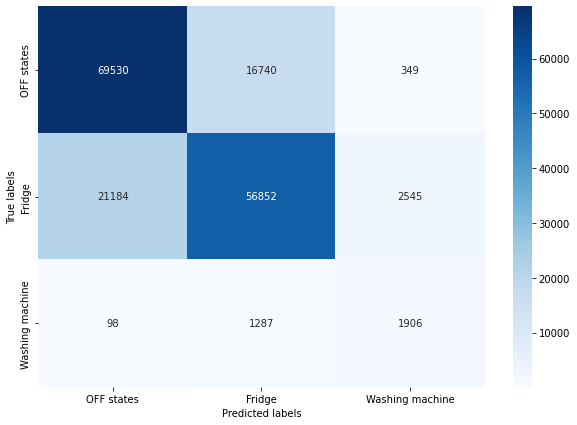

In [23]:
yhat = model.predict(X_test)
ypred = yhat.round()
model_scores(y_test, ypred)

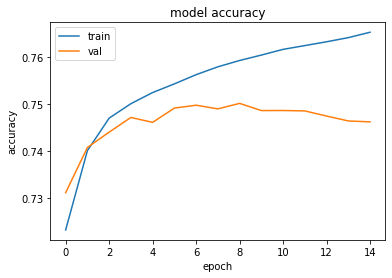

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

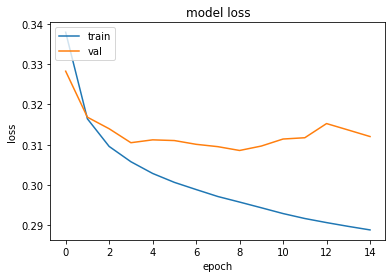

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### MLkNN

In [26]:
mlknn = MLkNN(k=3)
mlknn.fit(X_train, y_train)
mlknn_predictions = mlknn.predict(X_test)

Accuracy : 0.6297047938014323
Mean absolute error : 0.23852089944141727
              precision    recall  f1-score   support

           0       0.69      0.68      0.68     91510
           1       0.59      0.59      0.59     74257
           2       0.77      0.93      0.84      7570

   micro avg       0.65      0.65      0.65    173337
   macro avg       0.68      0.73      0.70    173337
weighted avg       0.65      0.65      0.65    173337
 samples avg       0.65      0.65      0.65    173337



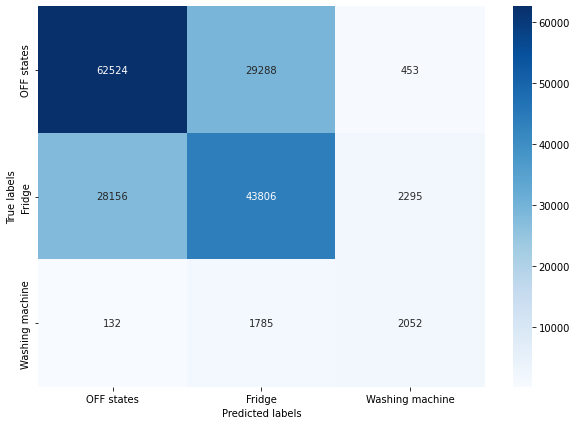

In [27]:
ypred = mlknn_predictions.toarray()
model_scores(y_test, ypred)

### RakEl

In [20]:
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD
from sklearn.ensemble import RandomForestClassifier

classifier = RakelD(
    base_classifier=RandomForestClassifier(),
    base_classifier_require_dense=[True, True],
    labelset_size=4
)

classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
ypred = predictions.toarray()

Accuracy : 0.763436193112833
Mean absolute error : 0.15095615995370235
              precision    recall  f1-score   support

           0       0.75      0.84      0.79     80989
           1       0.80      0.71      0.75     85047
           2       0.86      0.94      0.90      8408

   micro avg       0.78      0.78      0.78    174444
   macro avg       0.80      0.83      0.81    174444
weighted avg       0.78      0.78      0.78    174444
 samples avg       0.78      0.78      0.78    174444



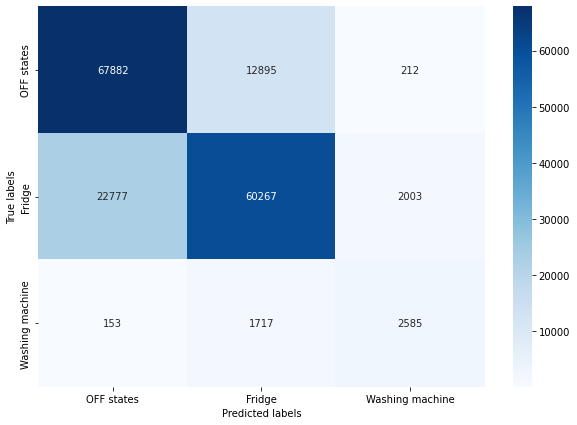

In [25]:
ypred = predictions.toarray()
model_scores(y_test, ypred)